### OLAP Queries

#### Funções utilitárias

In [3]:
import psycopg2 as pg
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

HOST = "10.101.151.25"
DATABASE = "tpd017"
USER = "tpd017"
PASSWORD = "tpd017" 

# Execute a single statement.
def execute_single_sql_statement(sql):
    conn = pg.connect(host=HOST,database=DATABASE, user=USER, password=PASSWORD)    
    cur = conn.cursor()
    cur.execute(sql)
    cur.close()
    conn.commit()
    conn.close()    

# Return output of query in dataframe
def getSQLfromQuery(sql, params):
    conn = pg.connect(host=HOST,database=DATABASE, user=USER, password=PASSWORD)
    cur  = conn.cursor()    
    if len(params)==0:
        cur.execute(sql)
    else: 
        cur.execute(sql, params)
    data = cur.fetchall()
    colnames = [desc[0] for desc in cur.description]
    cur.close()
    conn.close()
    df=pandafy(data, colnames)
    return df

# Create a dataframe
def pandafy(rows, colnames):
    N=len(colnames)
    D={cn: [] for cn in colnames}
    for row in rows:
        for i in range(N): D[colnames[i]].append(row[i])
    pdfy=pd.DataFrame(D)
    return pdfy


1. **Há algum período do dia onde ocorrem mais acidentes? Este padrão ocorre de forma semelhante para as várias regiões dos EUA? Esses períodos correspondem a horas de maior movimento, como rush hours?**


* **Objectivo da interrogação**: Analisar o número de ocorrências de acidentes ao nível da região e subregião (roll-up e drill-down) em relação ao período do dia.
* **Dimensões relevantes para a query**:
    * Facts Table: ligação entre as dimensões Location e LocalTIme (atributos `LocationKey` e `LocalTimeKey`)
    * Location: para agrupar as ocorrências segundo os atributos `Region` e `Subregion`
    * LocalTime: para agrupar as ocorrências segundo o atributo `PeriodOfDay`
* **Relevância para quais processos?**
    * Policiamento: dado o número de acidentes, adaptação de meios de vigiliância e cooperação

**Interrogação**:

``
SELECT l.region, l.subregion, t.period_of_day, COUNT(*) AS number_of_accidents
FROM local_time_dimension t, location_dimension l, facts_table ft
WHERE t.local_time_key = ft.local_timekey AND l.location_key = ft.locationkey
GROUP BY l.region, l.subregion, t.period_of_day
ORDER BY l.region DESC
``

In [4]:
SQL = """
SELECT l.region, l.subregion, t.period_of_day, COUNT(*) AS number_of_accidents
FROM local_time_dimension t, location_dimension l, facts_table ft
WHERE t.local_time_key = ft.local_timekey AND l.location_key = ft.locationkey
GROUP BY l.region, l.subregion, t.period_of_day
ORDER BY l.region DESC
"""

df = getSQLfromQuery(SQL, ())

In [5]:
table = pd.pivot_table(df, 
                       values=['number_of_accidents'], 
                       index=['region', 'subregion', 'period_of_day'], 
                       aggfunc={'number_of_accidents': np.sum},)

table

number_of_accidents
region                           subregion                        period_of_day                                        
Midwest                          East North Central               Day                                              1544
                                                                  Dusk                                              413
                                                                  Evening Rush Hour                                 604
                                                                  Lunch Time                                        359
                                                                  Morning Rush Hour                                 807
                                                                  Night                                             734
                                 West North Central               Day                                               669
                                                                  Dusk                                              225
                                                                  Evening Rush Hour                                 295
                                                                  Lunch Time                                        190
                                                                  Morning Rush Hour                                 312
                                                                  Night                                             311
Northeast                        Mid Atlantic                     Day                                              1732
                                                                  Dusk                                              402
                                                                  Evening Rush Hour                                 521
                                                                  Lunch Time                                        373
                                                                  Morning Rush Hour                                 865
                                                                  Night                                             677
                                 New England                      Day                                               521
                                                                  Dusk                                              139
                                                                  Evening Rush Hour                                 183
                                                                  Lunch Time                                         98
                                                                  Morning Rush Hour                                 201
                                                                  Night                                             136
South                            East South Central               Day                                               861
                                                                  Dusk                                              163
                                                                  Evening Rush Hour                                 285
                                                                  Lunch Time                                        156
                                                                  Morning Rush Hour                                 363
                                                                  Night                                             264
                                 South Atlantic                   Day                                              4129
                                                                  Dusk                                              983
                    

2. **Assumindo que os diferentes níveis de urbanismo nos municípios afetam a quantidade de tráfego nos mesmos, esse aumento também vai ocorrer no número de acidentes e na severidade dos mesmos?** 


* **Objetivo da interrogação**: Análise e visualização, para cada nível de urbanismo, do número de acidentes, e da distribuição da severidade nos mesmos, de modo a entender padrões à medida que o urbanismo aumenta.
* **Dimensões relevantes**: 
    * Facts Table: ligação à dimensão Location (atributo `LocationKey`)
    * Location: para recolha dos diferentes níveis de urbanismo (atributo `UrbanRuralClassification`)
    * Severity: para recolha das diferentes severidades dos acidentes (atributo-chave `SeverityKey`)
* **Relevância para quais processos?**
    * Seguradoras: adequação de valores através da prevalência de determinados acidentes em certas zonas
    * Policiamento: dado o número de acidentes, adaptação de meios de vigiliância e cooperação
    * Estruturas de controlo de tráfego: recolha de informação para identificação de zonas mais vulneráveis

**Interrogação**:

``
SELECT ft.severitykey, l.urban_rural_classification, COUNT(*) AS number_of_accidents
from facts_table ft, location_dimension l
WHERE ft.locationkey = l.location_key
GROUP BY l.urban_rural_classification, ft.severitykey
ORDER BY l.urban_rural_classification, ft.severitykey
``


In [6]:
SQL="""
SELECT ft.severitykey, l.urban_rural_classification, COUNT(*) AS number_of_accidents
from facts_table ft, location_dimension l
WHERE ft.locationkey = l.location_key
GROUP BY l.urban_rural_classification, ft.severitykey
ORDER BY l.urban_rural_classification, ft.severitykey
"""

df = getSQLfromQuery(SQL, ())

In [7]:
df['urban_rural_classification'] = df['urban_rural_classification'].apply(lambda x: x.rstrip())
df

,severitykey,urban_rural_classification,number_of_accidents
0,1,Large Central Metro,5
1,2,Large Central Metro,12664
2,3,Large Central Metro,5840
3,4,Large Central Metro,233
4,1,Large Fringe Metro,4
5,2,Large Fringe Metro,4504
6,3,Large Fringe Metro,2374
7,4,Large Fringe Metro,297
8,1,Medium Metro,4
9,2,Medium Metro,5234


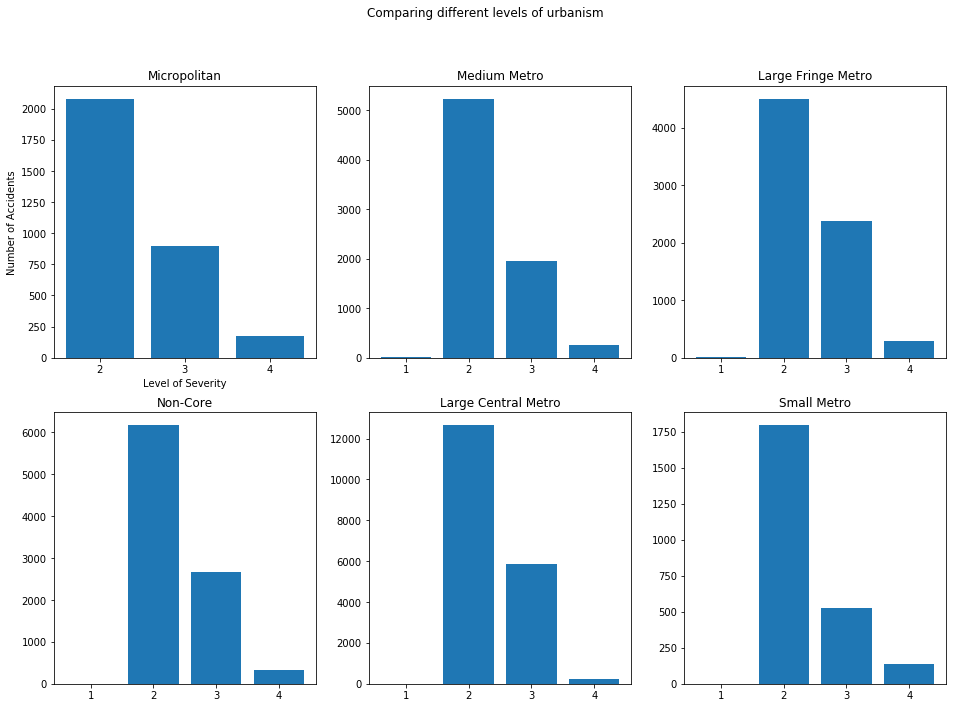

In [8]:
classes = list(set(df['urban_rural_classification'].values))
fig, axs = plt.subplots(2,3, figsize=(16,11))
fig.suptitle('Comparing different levels of urbanism')

for i, ax in enumerate(fig.axes):
    test = df.loc[df['urban_rural_classification'] == classes[i]].drop(columns=['urban_rural_classification'])
    ax.set_xticks(test['severitykey'].values)
    ax.bar(test['severitykey'].values, test['number_of_accidents'].values)
    ax.set_title(classes[i])
    if i == 0: 
        ax.set_xlabel("Level of Severity")
        ax.set_ylabel("Number of Accidents")
plt.show()

4. **Assumindo que a condição de 'piso escorregadio' influi negativamente nos acidentes, qual será o impacto de algumas condições metereológicas tipicamente associadas a esta condição na distância e duração média dos acidentes verificados?**


* **Objetivo da interrogação**: Análise e visualização, para os atributos metereológicos selecionados, a duração média e a distância média dos acidentes, de modo a entender os padrões que mais contribuem para acidentes tipicamente associados a piso escorregadio.

* **Dimensões relevantes**: 
    * Facts Table: ligação à dimensão Weather (atributo `weather_key`)
    * Weather: para recolha dos diferentes atributos metereológicos (atributos `precipitation`,`weathercondition`,`humidity` )
* **Relevância para quais processos?**
    * Estruturas de controlo de tráfego: estudo das condições e emissão de alertas aos condutores.

**Interrogação**:

``
Select weather_dimension.precipitation as precipitation, 
		weather_dimension.weather_condition as weathercondition, 
		weather_dimension.humidity as humidity, 
		avg(facts_table.distance) as average_distance,
		avg(facts_table.duration) as average_duration,
		count(*)
from facts_table, weather_dimension
where facts_table.weatherkey = weather_dimension.weather_key 
       and weather_dimension.precipitation not like '%Unknown%'
	   and weather_dimension.weather_condition not like '%Unknown%'
	   and weather_dimension.humidity not like '%Unknown%'
GROUP BY precipitation, weathercondition, humidity
order by average_duration desc
``


In [9]:
SQL="""
select weather_dimension.precipitation as precipitation, 
        weather_dimension.weather_condition as weathercondition, 
        weather_dimension.humidity as humidity, 
        avg(facts_table.distance) as average_distance,
        avg(facts_table.duration) as average_duration
from facts_table, weather_dimension
where facts_table.weatherkey = weather_dimension.weather_key 
       and weather_dimension.precipitation not like '%Unknown%'
       and weather_dimension.weather_condition not like '%Unknown%'
       and weather_dimension.humidity not like '%Unknown%'
GROUP BY precipitation, weathercondition, humidity
order by average_duration desc
"""

df = getSQLfromQuery(SQL, ())

In [10]:
df['precipitation'] = df['precipitation'].apply(lambda x: x.rstrip())
df['weathercondition'] = df['weathercondition'].apply(lambda x: x.rstrip())
df['humidity'] = df['humidity'].apply(lambda x: x.rstrip())

df

,precipitation,weathercondition,humidity,average_distance,average_duration
0,(Light) rate <= 0.1,Cloudy / Windy,(Very High) rate > 75.0,0.125118,06:43:37.470589
1,(Light) rate <= 0.1,Mostly Cloudy,(Very High) rate > 75.0,0.270676,06:13:49.174920
2,(Moderate) 0.1 < rate <= 0.3,Smoke,(Medium) 25.0 < rate <= 50.0,0.054000,06:00:00
3,(Moderate) 0.1 < rate <= 0.3,Smoke,(High) 50.0 < rate <= 75.0,0.110000,06:00:00
4,(Light) rate <= 0.1,Partly Cloudy / Windy,(Low) rate <= 25.0,0.508000,03:56:08.500000
...,...,...,...,...,...
233,(Light) rate <= 0.1,Light Rain / Windy,(High) 50.0 < rate <= 75.0,0.000000,00:29:24
234,(Violent) rate > 2.0,Heavy Rain,(Very High) rate > 75.0,0.000000,00:29:20
235,(Violent) rate > 2.0,Heavy Thunderstorms and Rain,(Very High) rate > 75.0,0.750000,00:29:15
236,(Light) rate <= 0.1,Showers in the Vicinity,(Medium) 25.0 < rate <= 50.0,0.341000,00:28:51


In [11]:
df['average_duration'] = df['average_duration'].astype(np.int64)

table = pd.pivot_table(df, values=['average_distance','average_duration'],margins=True, index=['precipitation', 'weathercondition', 'humidity'], aggfunc={'average_distance':np.mean, 'average_duration': np.mean})

table['average_duration'] = pd.to_timedelta(table['average_duration'])

table

average_distance  \
precipitation              weathercondition humidity                                         
(Heavy) 0.39 < rate <= 2.0 Clear            (High) 50.0 < rate <= 75.0            0.188357   
                                            (Low) rate <= 25.0                    0.006667   
                                            (Medium) 25.0 < rate <= 50.0          0.049300   
                                            (Very High) rate > 75.0               1.558053   
                           Cloudy           (Very High) rate > 75.0               1.695000   
...                                                                                    ...   
(Violent) rate > 2.0       Overcast         (Medium) 25.0 < rate <= 50.0          0.010000   
                                            (Very High) rate > 75.0               0.191000   
                           Partly Cloudy    (High) 50.0 < rate <= 75.0            0.029333   
                                            (Very High) rate > 75.0               0.088000   
All                                                                               0.606243   

                                                                         average_duration  
precipitation              weathercondition humidity                                       
(Heavy) 0.39 < rate <= 2.0 Clear            (High) 50.0 < rate <= 75.0    01:11:32.964286  
                                            (Low) rate <= 25.0            00:30:37.666667  
                                            (Medium) 25.0 < rate <= 50.0  00:37:50.200000  
                                            (Very High) rate > 75.0       00:32:35.315789  
                           Cloudy           (Very High) rate > 75.0       01:11:53.500000  
...                                                                                   ...  
(Violent) rate > 2.0       Overcast         (Medium) 25.0 < rate <= 50.0         00:44:30  
                                            (Very High) rate > 75.0              00:29:48  
                           Partly Cloudy    (High) 50.0 < rate <= 75.0    02:24:48.666667  
                                            (Very High) rate > 75.0       03:14:47.500000  
All                                                                       01:31:26.931142  

[239 rows x 2 columns]

2. **Tendo em conta a media de acidentes de 2019, quais os estados que ultrapassam a média? e qual a sua elvouluçõ ao longo dos 'utimos anos?**


* **Objetivo da interrogação**: Comparação do número de registos de acidentes nos ultimos anos, nos estados que mostram ter o maior numero de acidentes;

* **Dimensões relevantes**: 
    * Facts Table: ligação à dimensão Date (atributo `date_key`) e ligação à dimensão Location (atributo `location_key`) 
    * Date: para recolha dos anos registados nos vários acidentes
    * Location: para recolha dos states ue foram registados acidentes
* **Relevância para quais processos?**
    * Seguradoras: adequação de valores relativamente ao estado em que o veiculo está registado.
    
**Interrogação**:
``
SELECT location_dimension.state, date_dimension.start_year, COUNT(*) AS number_of_accidents
FROM location_dimension , date_dimension , facts_table 
WHERE facts_table.locationkey = location_dimension.location_key
    AND facts_table.datekey = date_dimension.date_key 
    AND location_dimension.state IN 
                 (SELECT location_dimension.state
                FROM location_dimension , date_dimension , facts_table 
                WHERE  facts_table.locationkey = location_dimension.location_key
                    AND facts_table.datekey = date_dimension.date_key 
                    AND date_dimension.start_year = 2019
                GROUP BY location_dimension.state 
                HAVING COUNT(*) >  """+ str(media)+""" 
                )
    GROUP BY date_dimension.start_year,location_dimension.state
    ORDER BY location_dimension.state
``



In [95]:
SQL="""
SELECT COUNT(*) AS number_of_accidents
FROM location_dimension , date_dimension , facts_table 
WHERE  facts_table.locationkey = location_dimension.location_key
    AND facts_table.datekey = date_dimension.date_key 
    AND date_dimension.start_year = 2019


"""
df = getSQLfromQuery(SQL, ())
numero = df.values

SQL="""
SELECT Count( Distinct location_dimension.state )
FROM location_dimension 

"""

df = getSQLfromQuery(SQL, ())
media = (numero [0] /df.values[0])[0]
media

337.95652173913044

In [106]:
SQL="""

SELECT location_dimension.state, date_dimension.start_year, COUNT(*) AS number_of_accidents
FROM location_dimension , date_dimension , facts_table 
WHERE facts_table.locationkey = location_dimension.location_key
    AND facts_table.datekey = date_dimension.date_key 
    AND location_dimension.state IN 
                 (SELECT location_dimension.state
                FROM location_dimension , date_dimension , facts_table 
                WHERE  facts_table.locationkey = location_dimension.location_key
                    AND facts_table.datekey = date_dimension.date_key 
                    AND date_dimension.start_year = 2019
                GROUP BY location_dimension.state 
                HAVING COUNT(*) >  """+ str(media)+""" 
                )
    GROUP BY date_dimension.start_year,location_dimension.state
    ORDER BY location_dimension.state
"""


df =  getSQLfromQuery(SQL, ())
df

,state,start_year,number_of_accidents
0,Arizona ...,2017,211
1,Arizona ...,2018,382
2,Arizona ...,2019,411
3,Arizona ...,2016,48
4,California ...,2019,3674
5,California ...,2016,2380
6,California ...,2018,2575
7,California ...,2017,2637
8,Florida ...,2019,979
9,Florida ...,2016,605


In [116]:
table = pd.pivot_table(df, index= ['state'],margins=True, columns=['start_year'] )
table = table.astype(int)
table

number_of_accidents        \
start_year                                                        2016  2017   
state                                                                          
Arizona                                        ...                  48   211   
California                                     ...                2380  2637   
Florida                                        ...                 605  1036   
Georgia                                        ...                 182   353   
Minnesota                                      ...                  45   182   
New York                                       ...                 299   632   
North Carolina                                 ...                  97   590   
Oregon                                         ...                  15   109   
South Carolina                                 ...                  50   442   
Tennessee                                      ...                  23   196   
Texas                                          ...                 843  1471   
Utah                                           ...                  11    61   
All                                                                383   660   

                                                                      
start_year                                          2018  2019   All  
state                                                                 
Arizona                                        ...   382   411   263  
California                                     ...  2575  3674  2816  
Florida                                        ...  1039   979   914  
Georgia                                        ...   412   371   329  
Minnesota                                      ...   310   534   267  
New York                                       ...   634   701   566  
North Carolina                                 ...   967   842   624  
Oregon                                         ...   373   698   298  
South Carolina                                 ...  1001  1020   628  
Tennessee                                      ...   450   396   266  
Texas                                          ...  1429  1338  1270  
Utah                                           ...   181   414   166  
All                                                  812   948   701